In [42]:
# We complexify the previoius model
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [43]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [44]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [45]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [46]:
# build the dataset
block_size = 16 # context length: how many characters do we take to predict the next one?


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 16]) torch.Size([182625])
torch.Size([22655, 16]) torch.Size([22655])
torch.Size([22866, 16]) torch.Size([22866])


In [47]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / \
            fan_in**0.5  # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)  # batch mean
            xvar = x.var(dim, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * \
                    self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * \
                    self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
    
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim)) 

    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    def __init__(self, n ):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n , C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [48]:
n_embd = 12
n_hidden = 32



layers = [
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),
    Linear(n_embd * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size) 
]
model = Sequential(layers)
skip_layer = Linear(n_embd * block_size, vocab_size, bias=True)

with torch.no_grad():
    layers[-1].weight *= 0.1  # make less confident
    skip_layer.weight *= 0.1  # make less confident

parameters = [p for l in layers for p in l.parameters()] + [skip_layer.weight, skip_layer.bias]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

13594


In [50]:
# define lr and iterations arrays
lr = [0.1, 0.01, 0.005]
iterations = [100000, 100000, 100000]
total_iterations = 0 # keep track of total iterations
batch_size = 128
lossi = [] # keep track of loss

# loop through pairs of lr and iterations
for lr, it in zip(lr, iterations):
    for i in range(it):
        
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
        
        # forward pass
        emb = layers[0](Xb) # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        x = model(Xb)
        x = x + skip_layer(embcat)
        loss = F.cross_entropy(x, Yb)


        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # update
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % 1000 == 0 or i == it - 1:
            print(f'Learning rate: {lr}, Iteration number: {total_iterations}/{sum(iterations)}, Loss: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        total_iterations += 1



Learning rate: 0.1, Iteration number: 0/300000, Loss: 2.2367
Learning rate: 0.1, Iteration number: 1000/300000, Loss: 2.2405
Learning rate: 0.1, Iteration number: 2000/300000, Loss: 2.1059
Learning rate: 0.1, Iteration number: 3000/300000, Loss: 2.1802
Learning rate: 0.1, Iteration number: 4000/300000, Loss: 2.2141
Learning rate: 0.1, Iteration number: 5000/300000, Loss: 2.1177
Learning rate: 0.1, Iteration number: 6000/300000, Loss: 1.9876
Learning rate: 0.1, Iteration number: 7000/300000, Loss: 1.9972
Learning rate: 0.1, Iteration number: 8000/300000, Loss: 2.0962
Learning rate: 0.1, Iteration number: 9000/300000, Loss: 2.0699
Learning rate: 0.1, Iteration number: 10000/300000, Loss: 2.0775
Learning rate: 0.1, Iteration number: 11000/300000, Loss: 2.2604
Learning rate: 0.1, Iteration number: 12000/300000, Loss: 1.8376
Learning rate: 0.1, Iteration number: 13000/300000, Loss: 2.1690
Learning rate: 0.1, Iteration number: 14000/300000, Loss: 2.1011
Learning rate: 0.1, Iteration number: 

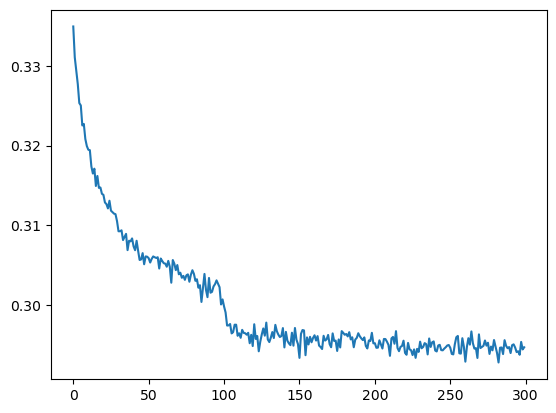

In [51]:
#lossi = torch.tensor(lossi)
#lossi = lossi.view((-1, 1000)).mean(dim=1)
plt.plot(torch.tensor(lossi).view((-1, 1000)).mean(dim=1))

In [52]:
for layer in layers:
    layer.training = False

In [53]:
# evaluate the loss
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = layers[0](x)
    x = model(x)
    embcat = emb.view(emb.shape[0], -1)
    x += skip_layer(embcat)
    loss = F.cross_entropy(x, y)
    

    print(split, loss.item())


split_loss('train')
split_loss('val')

train 1.96418035030365
val 2.0578064918518066


In [61]:
def sample(num_samples=20):
    samples = []
    for i in range(num_samples):
        out = []
        context = [0] * block_size
        while True:
            x = torch.tensor(context[-block_size:]).unsqueeze(0)
            emb = layers[0](x)

            x = model(x)
            embcat = emb.view(emb.shape[0], -1)
            x += skip_layer(embcat)
            x = x.squeeze()
            x = F.softmax(x, dim=-1)
            x = torch.multinomial(x, 1).item()
            if x == 0:
                break
            out.append(itos[x])
            context = context[1:] + [x]
        samples.append(''.join(out))
    return samples

sample = sample()
for s in sample:
    if s not in words:
        print(s)

palili
jadison
zlen
leighan
knaidi
writtom
ahrina
kauva
nadhi
ivanne
gemiels
diom
teriergen
shrustin
aadira
knellemi
